!pip install phik -q
!pip install catboost -q
!pip install 
!pip install dython

# Проект "Машинки"

**Описание исследования:**

Наше исследование направлено на создание модели, предсказывающей рыночную стоимость автомобиля по вхоным параметрам для сервиса "Не бит, не крашен". Заказчик попросил использовать LightGBM и другие модели по нашему выбору. Заказчик указал, что ему особенно важны качество модели, время её работы и время обучения. В качестве метрики качества будет использоваться RMSE

**Цель исследования:**
Подобрать модель машинного обучения для предсказания рыночной цены на авто

**Задачи исследования:**

1. Проверить данные на выбросы, дубликаты и пропуски
2. Провести исследоватеорреляционный анализ
3. Подготовить данные для моделей
4. Обучить модели
5. Выбрать самую мощную модель по качеству метрики, времени обучения и времени предсказания

**Описание данных:**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
- Price — цена (евро)

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import phik
import catboost
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

    
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [59]:
def info_about_df(df):
    display(df.head(10))
    df.info()

    numeric_columns = df.select_dtypes(include=['number']).columns
   


    for column in numeric_columns:
        plt.figure(figsize=(12, 15))
        plt.hist(df[column], bins=20, color='lightcoral', edgecolor='black')
        plt.title(f'Гистограмма для колонки {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show()

In [60]:
def reader(name):
    try:
        data_train = pd.read_csv(f'/datasets/{name}.csv')
    except:
        data_train = pd.read_csv(f'C:/Users/simuk/Desktop/IT/проект/{name}.csv')
    return data_train

In [61]:
df = reader('autos')

**Предвариельный анализ**

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

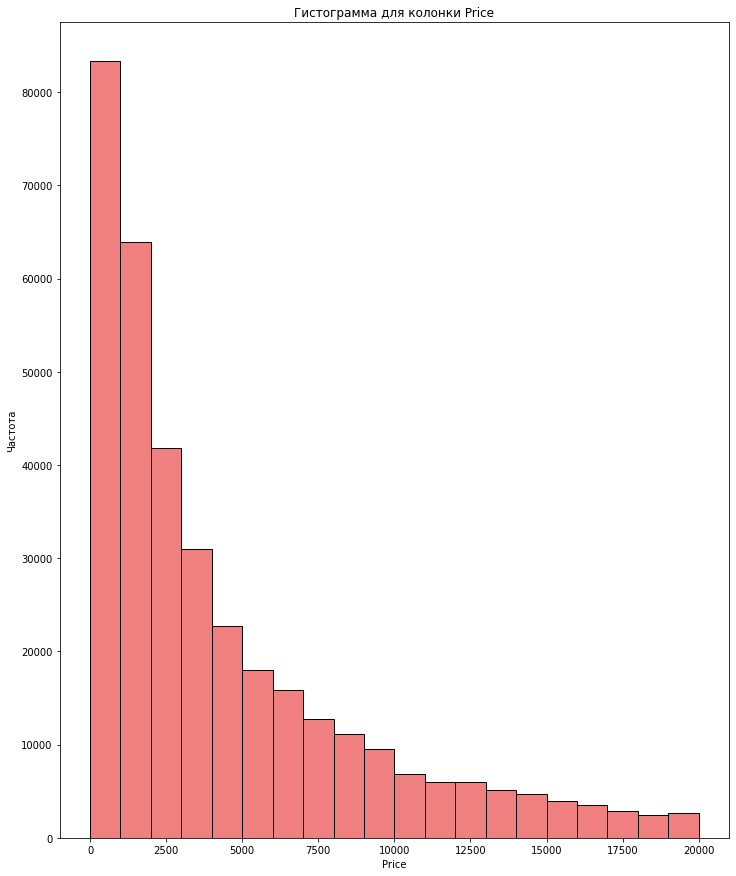

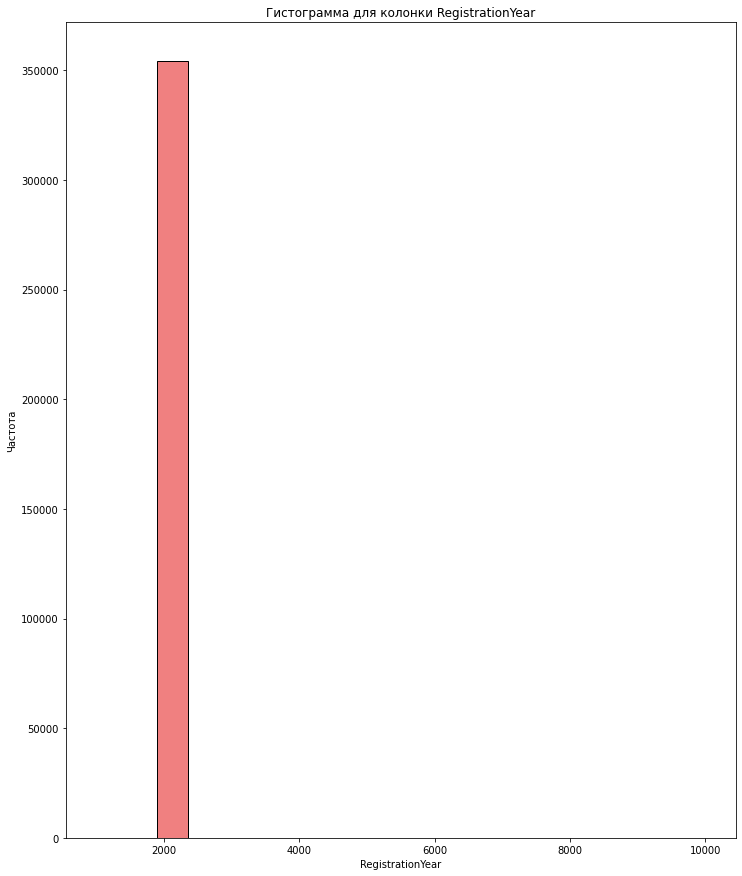

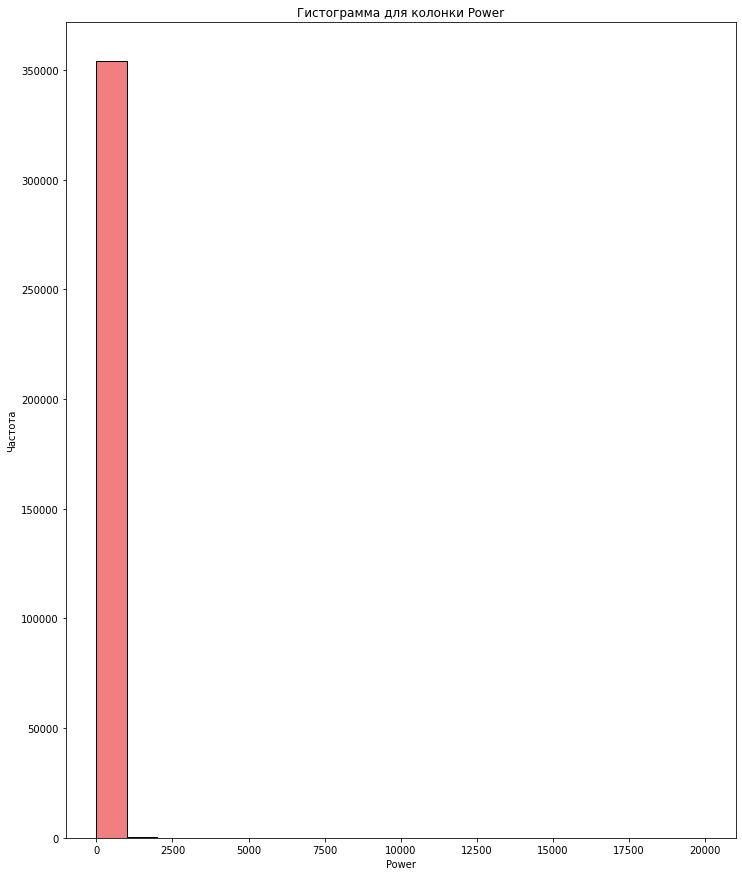

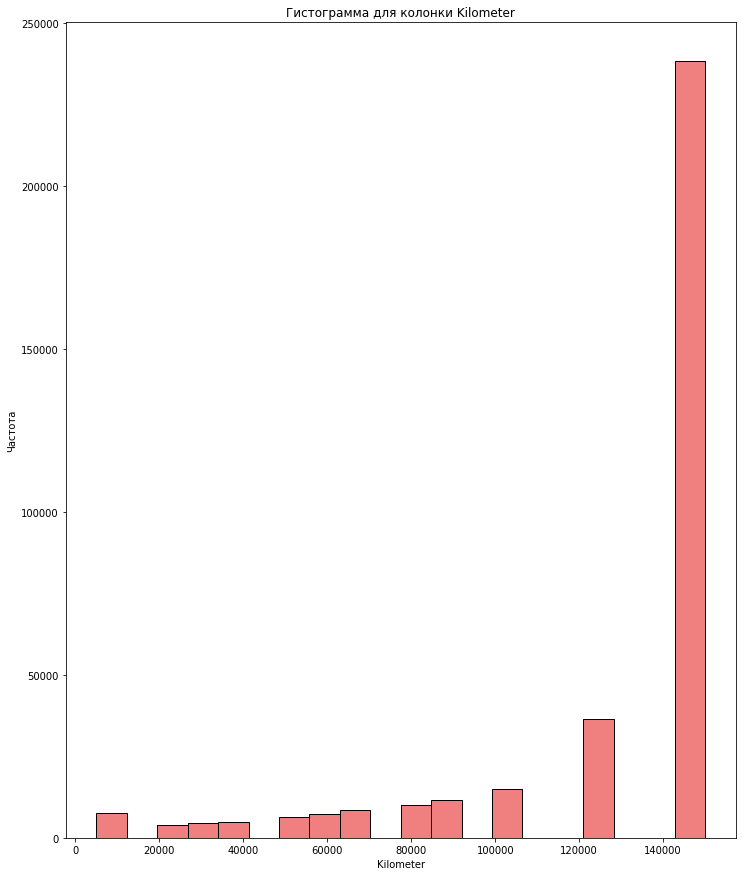

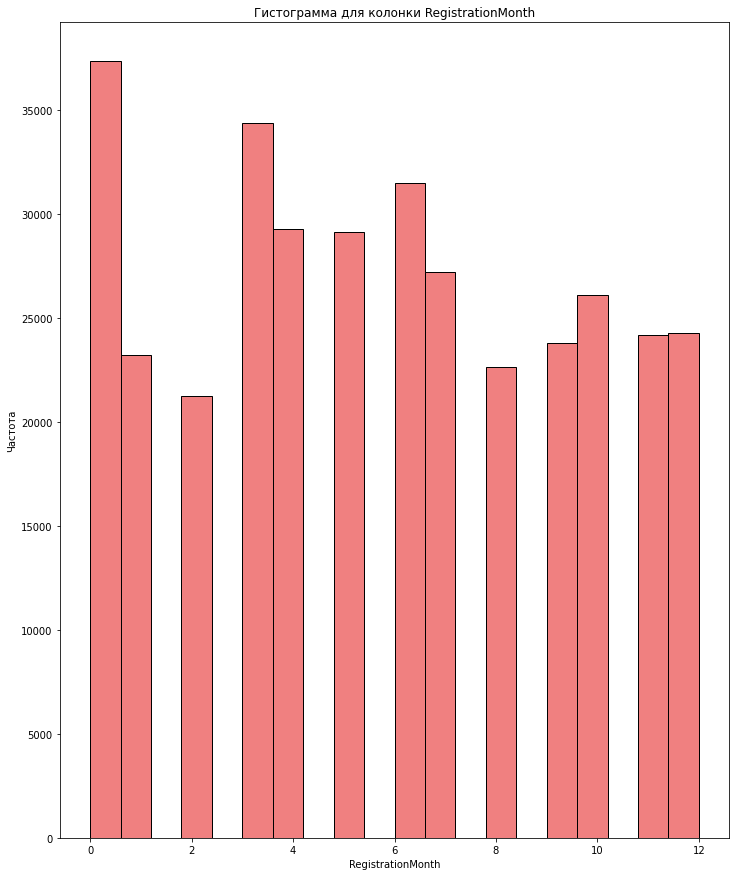

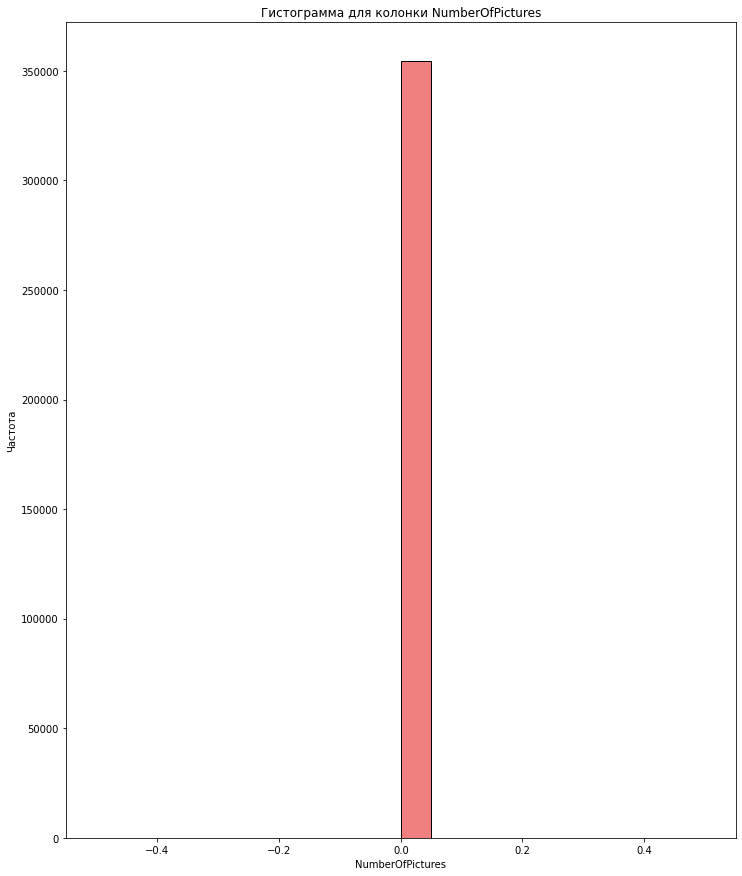

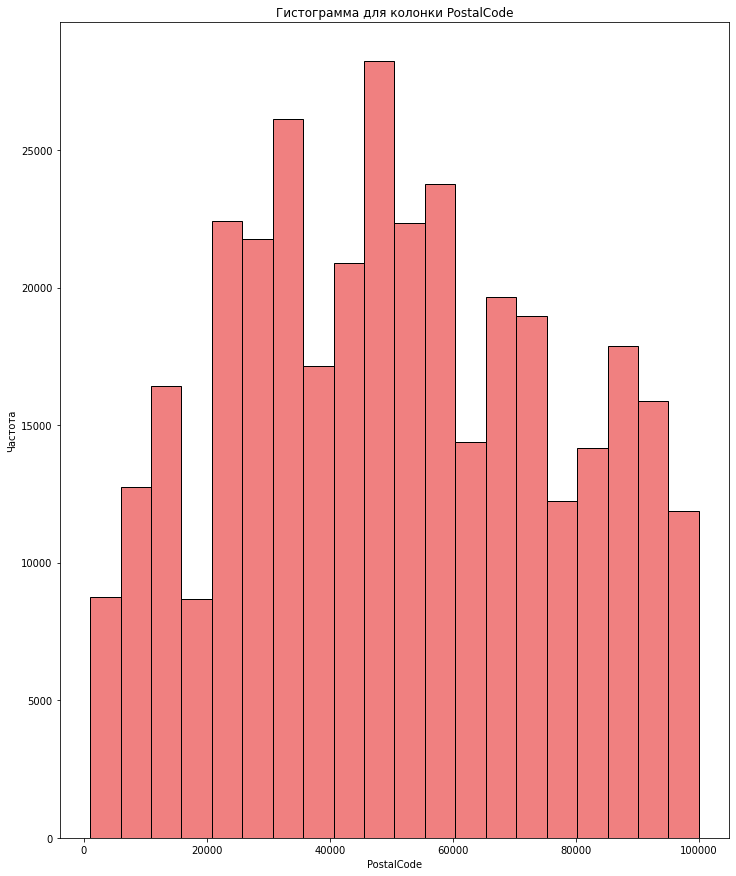

In [62]:
info_about_df(df)

In [63]:
def object_info(column):
    plt.figure(figsize=(15, 14))
    sns.countplot(data=df, x=column, color='skyblue')
    plt.title(f'Барплот для колонки {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

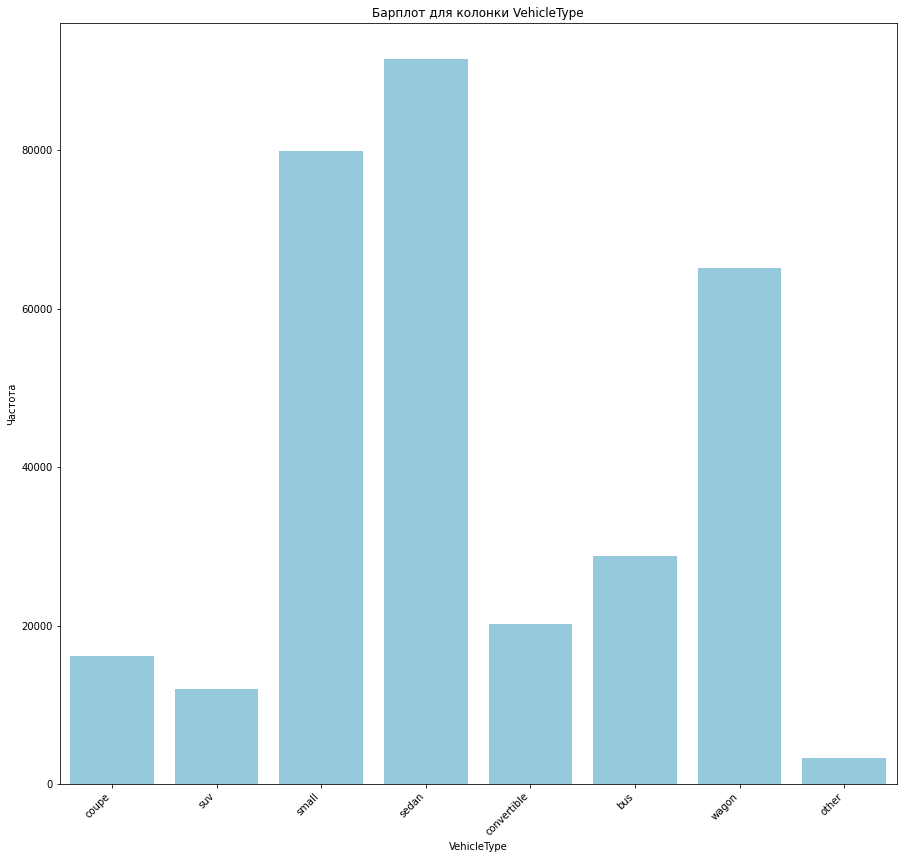

In [65]:
object_info('VehicleType')

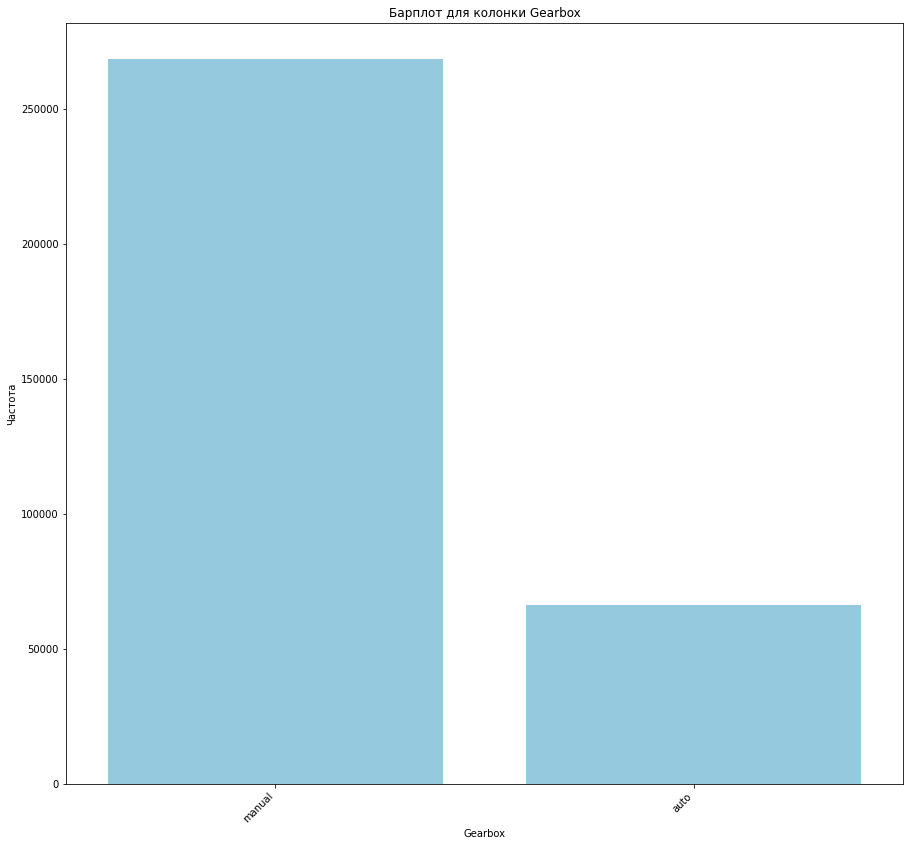

In [66]:
object_info('Gearbox')

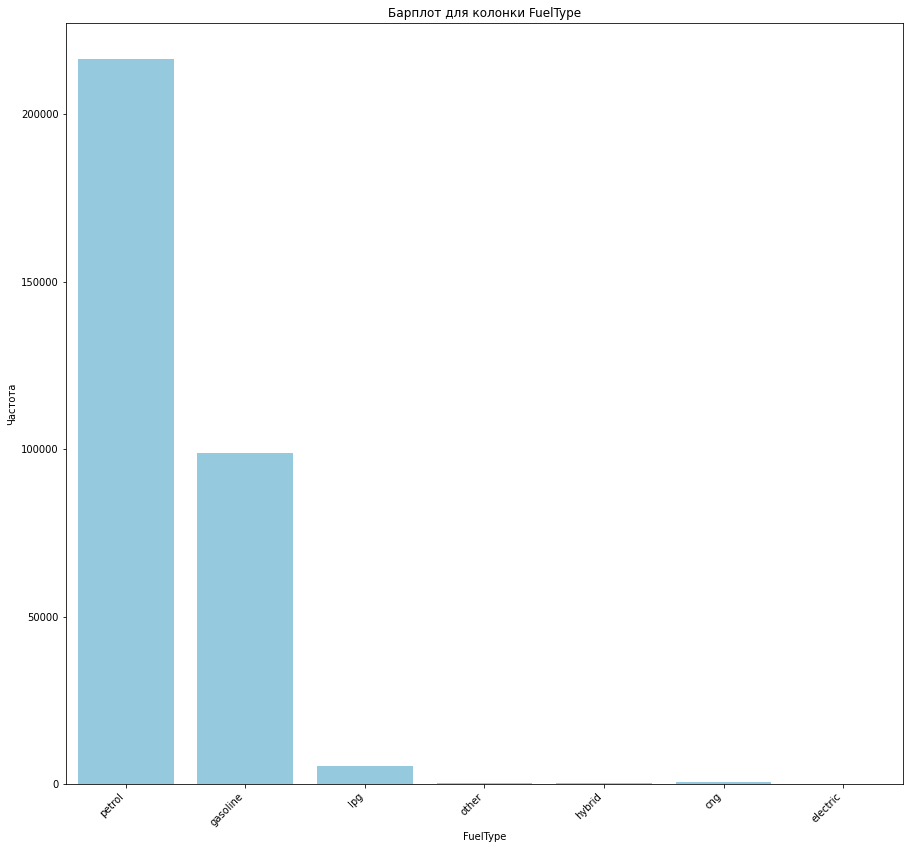

In [67]:
object_info('FuelType')

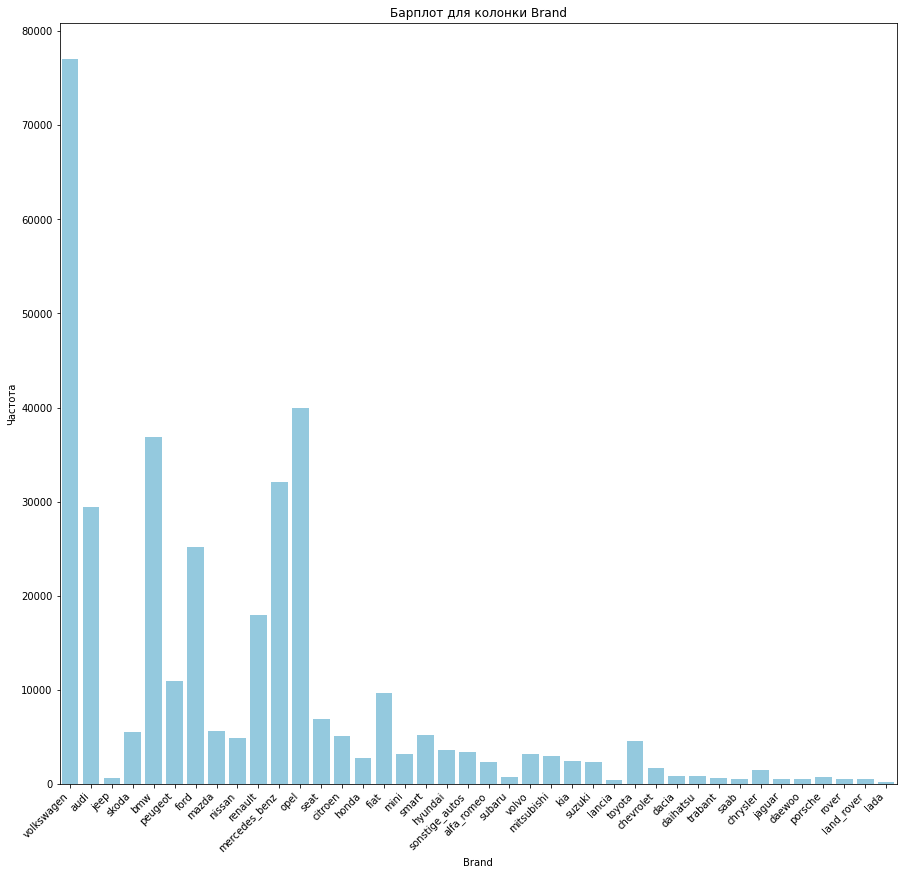

In [68]:
object_info('Brand')

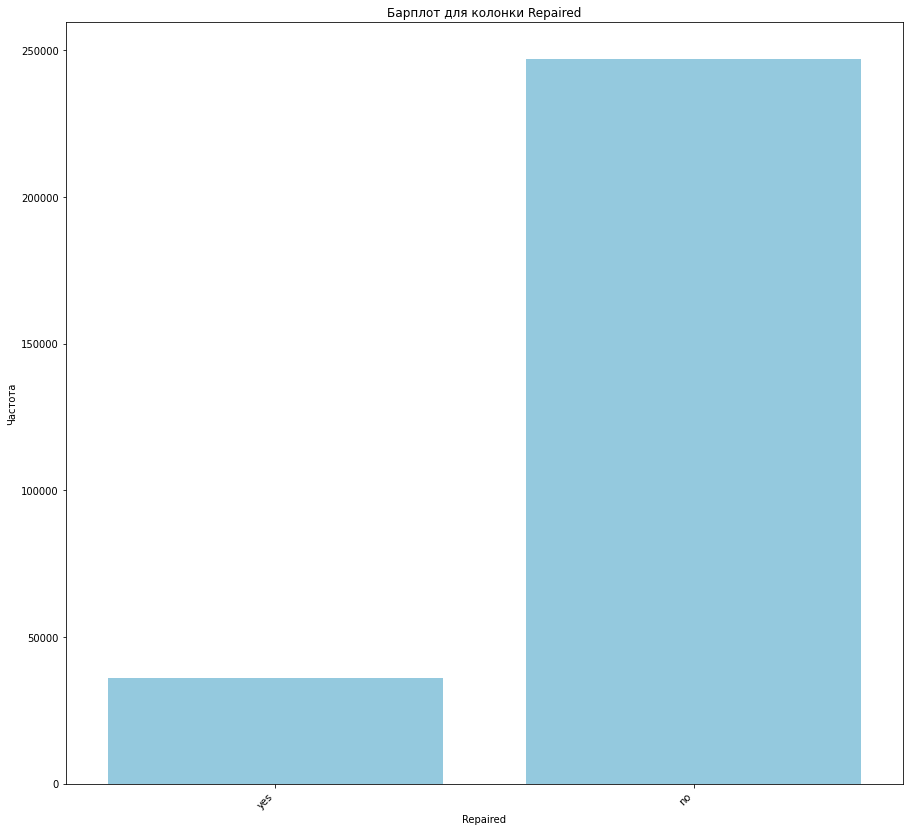

In [69]:
object_info('Repaired')

**Итоги предварительного анализа:**

1. Некоторые пользователи не указали тип кузова. Для дальнейшей работы будут пропуски заменены на Самый попуярный - седан. 
2. Не хватает данных по типу топлива у некоторых машин. Для дальейшей работы будут заменены самым используемым типом топлива - Petrol
3. Есть пропуски в моделях автомобилей. Это важный показатель, поэтому строки с пропусками будут удалены
4. Также мало данных в признаке, отражающим была ли машина в ремонте. Вероятнее всего люди не указывали данный показатель, когда заполняли анкету. если их машина не была в ремонте, поэтому пропуски мы заменим на no.
5. На гистограммах видны вбыросы в данных по колонкам: RegistrationYear, Poweк
6. NumberOfPictures имеет одни нули, поэтому эти данные мы уберём из итогового анализа

# Предобработка данных

In [70]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [72]:
def columns_to_lowercase(df):
    df.columns = df.columns.str.lower()
    return df

In [73]:
df = columns_to_lowercase(df)

In [74]:
list_dublicate = df.columns
list_dublicate

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [75]:
def remove_duplicates(name, list_duplicate):
    print(name.duplicated(subset=list_duplicate).sum())
    name = name.drop_duplicates(subset=list_duplicate)
    return name

In [76]:
def anomaly(df):
    object_columns = df.select_dtypes(exclude='object').columns
    for column in object_columns:
        
        plt.figure(figsize=(8, 6))
        plt.boxplot(df[column])
        plt.title(f'Boxplot for {column}')
        plt.show()
        print(df[column].describe())

In [77]:
df = remove_duplicates(df, list_dublicate)

4


In [78]:
def year_column(datetime_column):

    return datetime_column.dt.year

In [79]:
df[['datecrawled','datecreated', 'lastseen']] = df[['datecrawled','datecreated', 'lastseen']].apply(pd.to_datetime)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354365 non-null  datetime64[ns]
 1   price              354365 non-null  int64         
 2   vehicletype        316875 non-null  object        
 3   registrationyear   354365 non-null  int64         
 4   gearbox            334532 non-null  object        
 5   power              354365 non-null  int64         
 6   model              334660 non-null  object        
 7   kilometer          354365 non-null  int64         
 8   registrationmonth  354365 non-null  int64         
 9   fueltype           321470 non-null  object        
 10  brand              354365 non-null  object        
 11  repaired           283211 non-null  object        
 12  datecreated        354365 non-null  datetime64[ns]
 13  numberofpictures   354365 non-null  int64   

In [81]:
df['datecrawled'] = year_column(df['datecrawled'])
df['datecreated'] = year_column(df['datecreated'])
df['lastseen'] = year_column(df['lastseen'])

In [82]:
df['registrationmonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

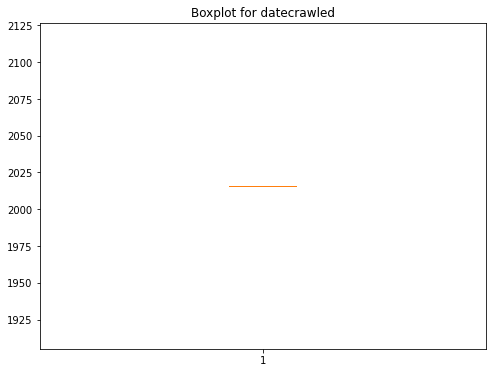

count    354365.0
mean       2016.0
std           0.0
min        2016.0
25%        2016.0
50%        2016.0
75%        2016.0
max        2016.0
Name: datecrawled, dtype: float64


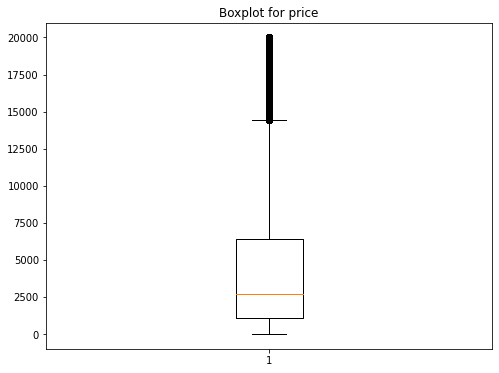

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64


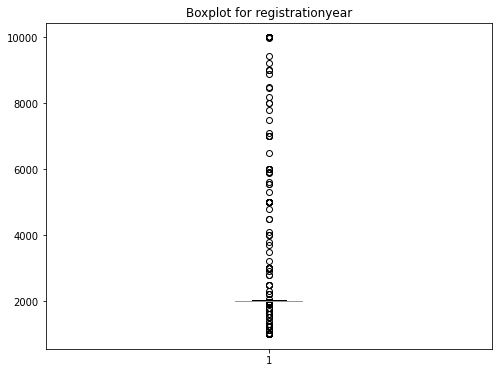

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64


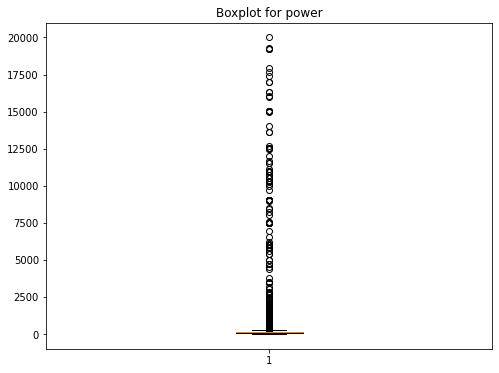

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


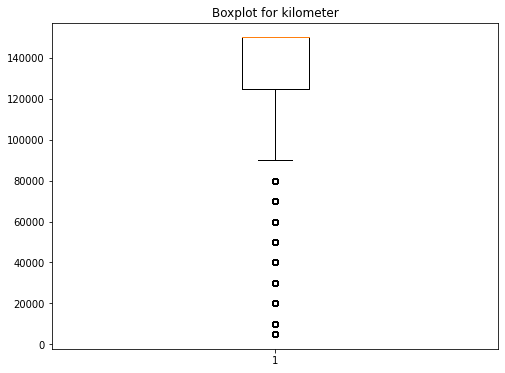

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


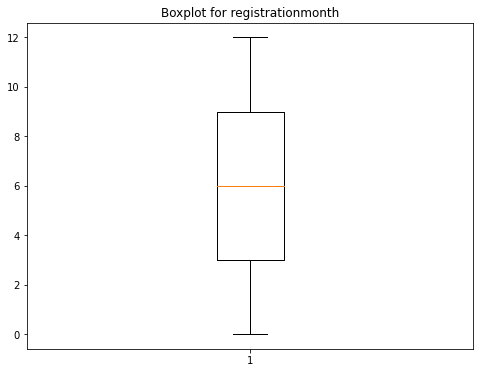

count    354365.000000
mean          5.714650
std           3.726432
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registrationmonth, dtype: float64


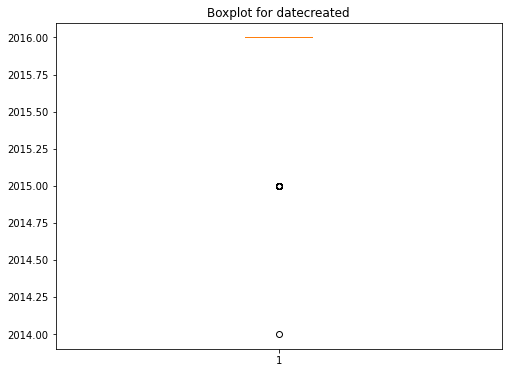

count    354365.000000
mean       2015.999924
std           0.009046
min        2014.000000
25%        2016.000000
50%        2016.000000
75%        2016.000000
max        2016.000000
Name: datecreated, dtype: float64


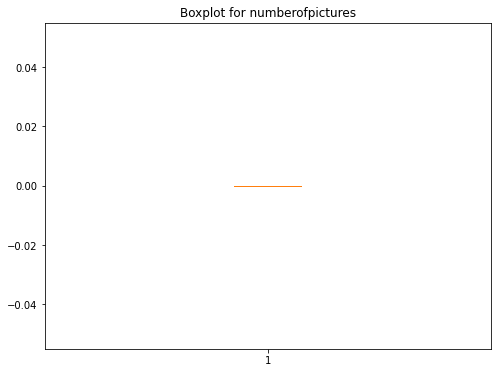

count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: numberofpictures, dtype: float64


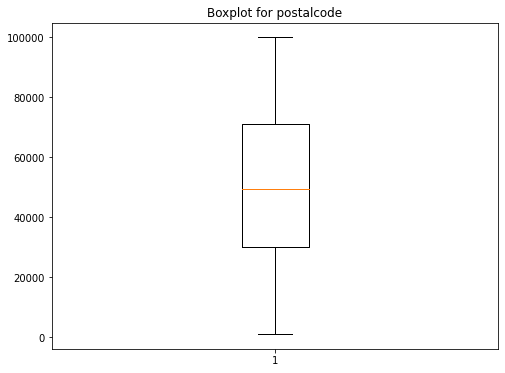

count    354365.000000
mean      50508.503800
std       25783.100078
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: postalcode, dtype: float64


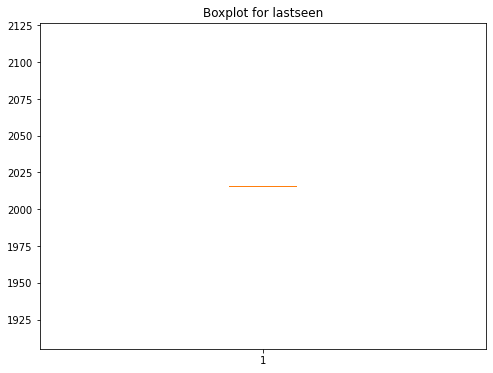

count    354365.0
mean       2016.0
std           0.0
min        2016.0
25%        2016.0
50%        2016.0
75%        2016.0
max        2016.0
Name: lastseen, dtype: float64


In [83]:
anomaly(df)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354365 non-null  int64 
 1   price              354365 non-null  int64 
 2   vehicletype        316875 non-null  object
 3   registrationyear   354365 non-null  int64 
 4   gearbox            334532 non-null  object
 5   power              354365 non-null  int64 
 6   model              334660 non-null  object
 7   kilometer          354365 non-null  int64 
 8   registrationmonth  354365 non-null  int64 
 9   fueltype           321470 non-null  object
 10  brand              354365 non-null  object
 11  repaired           283211 non-null  object
 12  datecreated        354365 non-null  int64 
 13  numberofpictures   354365 non-null  int64 
 14  postalcode         354365 non-null  int64 
 15  lastseen           354365 non-null  int64 
dtypes: int64(10), object

In [85]:
quantile_5th = st.mstats.mquantiles(df['price'], 0.05)
quantile_5th

array([200.])

In [86]:
df = df.drop(['datecrawled', 'datecreated', 'lastseen'], axis=1)

In [87]:
df = df[df['price']>200]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334917 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              334917 non-null  int64 
 1   vehicletype        304047 non-null  object
 2   registrationyear   334917 non-null  int64 
 3   gearbox            319643 non-null  object
 4   power              334917 non-null  int64 
 5   model              318553 non-null  object
 6   kilometer          334917 non-null  int64 
 7   registrationmonth  334917 non-null  int64 
 8   fueltype           308156 non-null  object
 9   brand              334917 non-null  object
 10  repaired           273312 non-null  object
 11  numberofpictures   334917 non-null  int64 
 12  postalcode         334917 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 35.8+ MB


In [88]:
df = df[df['registrationyear'] > 1960]
df = df[df['registrationyear'] <2024]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334458 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              334458 non-null  int64 
 1   vehicletype        303764 non-null  object
 2   registrationyear   334458 non-null  int64 
 3   gearbox            319373 non-null  object
 4   power              334458 non-null  int64 
 5   model              318284 non-null  object
 6   kilometer          334458 non-null  int64 
 7   registrationmonth  334458 non-null  int64 
 8   fueltype           307868 non-null  object
 9   brand              334458 non-null  object
 10  repaired           273088 non-null  object
 11  numberofpictures   334458 non-null  int64 
 12  postalcode         334458 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 35.7+ MB


In [89]:
df = df[df['power'] < 1000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334186 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              334186 non-null  int64 
 1   vehicletype        303527 non-null  object
 2   registrationyear   334186 non-null  int64 
 3   gearbox            319112 non-null  object
 4   power              334186 non-null  int64 
 5   model              318040 non-null  object
 6   kilometer          334186 non-null  int64 
 7   registrationmonth  334186 non-null  int64 
 8   fueltype           307646 non-null  object
 9   brand              334186 non-null  object
 10  repaired           272913 non-null  object
 11  numberofpictures   334186 non-null  int64 
 12  postalcode         334186 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 35.7+ MB


In [90]:
df = df.drop('numberofpictures', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334186 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              334186 non-null  int64 
 1   vehicletype        303527 non-null  object
 2   registrationyear   334186 non-null  int64 
 3   gearbox            319112 non-null  object
 4   power              334186 non-null  int64 
 5   model              318040 non-null  object
 6   kilometer          334186 non-null  int64 
 7   registrationmonth  334186 non-null  int64 
 8   fueltype           307646 non-null  object
 9   brand              334186 non-null  object
 10  repaired           272913 non-null  object
 11  postalcode         334186 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 33.1+ MB


In [91]:
def count_missing_values(df):

    missing_values = df.isna().sum()
    return missing_values[missing_values > 0]

In [92]:
count_missing_values(df)

vehicletype    30659
gearbox        15074
model          16146
fueltype       26540
repaired       61273
dtype: int64

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274507 entries, 2 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              274507 non-null  int64 
 1   vehicletype        274507 non-null  object
 2   registrationyear   274507 non-null  int64 
 3   gearbox            274507 non-null  object
 4   power              274507 non-null  int64 
 5   model              274507 non-null  object
 6   kilometer          274507 non-null  int64 
 7   registrationmonth  274507 non-null  int64 
 8   fueltype           274507 non-null  object
 9   brand              274507 non-null  object
 10  repaired           274507 non-null  object
 11  postalcode         274507 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 27.2+ MB


In [99]:
df = df.dropna()

**Результаты предобработки:**
1. Удалены явные дубликаты
2. В столбце price были необычные предлоения по продаже за 0 евро. Для исключения данных, которые могут плохо повлиять на качество обучения модели они были убраны до 5% квантиля.
3. В столбце по дате регистрации автомобиля были мшаины. зарегестрирвоанные в 1000 годы при крестоносцах и настояющие дэлорианы докторы Брауна из 9999 года. Для более качественной настройки модели взяты данные с 1900 по 2024 год
4. В даных оказались аномально высокие показатели мощности двигатели. Вероятно продавцы случайно добавляли несколько нулей. В рамках предобработки были удалены автомобили с мощностью более 1000 л.с
5. Данные о пробеге столкнулись с явным лимитом вводимых значений, поэтому для дальнейшей работы будет создана категориальная перемнная, состоящая из "более 15000 км" и "менее 15000 км". Старые данные удалены не будут, вместо этого будет проведено исследование, какой из вариантов даст большую точность для модели. 
6. Столбец с количеством фотографий пуст. Удаляем его. 
7. Данные о дате скачивания анкеты, последнем посещении владельца анкеты и дате регитсрации анкеты почти одинаковые и не нужны lzk дальнейшего анализа. Удалим их. 

# Исследовательский анализ данных

In [36]:
def histagramma(m, name):
    counts = m[f'{name}']
    print(counts.describe())
    plt.figure(figsize=(10, 6))
    plt.hist(counts, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(np.median(counts), color='red',
                linestyle='dashed', linewidth=2, label='Медиана')
    plt.axvline(np.mean(counts), color='green',
                linestyle='dashed', linewidth=2, label='Среднее')
    plt.axvline(np.percentile(counts, 25), 
                color='orange', linestyle='dashed', linewidth=2, label='1-й квартиль')
    plt.axvline(np.percentile(counts, 75),
                color='blue', linestyle='dashed', linewidth=2, label='3-й квартиль')
        
    plt.legend()

    plt.title(f'{name}')
    plt.xlabel(f'Значения')
    plt.ylabel('Частота')
    plt.show()

In [37]:

def barplot(dataframe, column_name):

    value_counts = dataframe[column_name].value_counts()

    percentages = (value_counts / value_counts.sum() * 100).round(2)
    

    results_table = pd.DataFrame({
        'Количество': value_counts,
        'Проценты': percentages
    })

    print(f'Результаты подсчёта для столбца "{column_name}":')
    print(results_table)
    print("\n")  
    plt.figure(figsize=(10, 6))
    bars = value_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Барплот для столбца "{column_name}"')
    plt.xlabel(column_name)
    plt.ylabel('Количество')
    
 
    for bar, percentage in zip(bars.patches, percentages):
        y = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        bars.annotate(f'{percentage}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.show()


In [38]:
def pie(df, param):
    breed_counts = df[f'{param}'].value_counts()
    print(breed_counts)
    plt.pie(breed_counts, labels=breed_counts.index, autopct='%1.1f%%', startangle=140)

    plt.title(f'Круговая диаграмма распределения для показателя {param}')


    plt.show()

In [39]:
def mean_target(df, param, target):
    mean_target_by_param = df.groupby(param)[target].mean().reset_index()

    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(x=param, y=target, data=mean_target_by_param)
    plt.title(f'Average {target} by {param}')
    plt.xlabel(param)
    plt.ylabel(f'Average {target}')

    # Добавление подписей значений над каждым столбцом
    for index, value in enumerate(mean_target_by_param[target]):
        barplot.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.show()

In [40]:
def mean_target(df, param, target):
    # Группировка и расчет среднего, сброс индекса для облегчения сортировки
    mean_target_by_param = df.groupby(param)[target].mean().reset_index()
    
    # Сортировка значений по целевому столбцу
    mean_target_by_param = mean_target_by_param.sort_values(by=target, ascending=False)

    # Вывод группировки в виде таблицы
    print("Таблица средних значений:")
    print(mean_target_by_param)
    
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(x=param, y=target, data=mean_target_by_param)
    plt.title(f'Average {target} by {param}')
    plt.xlabel(param)
    plt.ylabel(f'Average {target}')
    
    # Вертикальное разворачивание подписей
    plt.xticks(rotation=90)  # Поворот подписей на оси X на 90 градусов

    # Добавление подписей значений над каждым столбцом
    for index, value in enumerate(mean_target_by_param[target]):
        barplot.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()  # Автоматическое корректирование подписей, меток и т.д. для их лучшего отображения
    plt.show()



In [41]:
def link(df, name, target):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=df[f'{name}'], y=df[f'{target}'], data=df)
    plt.title(f'Scatter Plot для {name} и {target}')
    plt.show()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334186 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              334186 non-null  int64 
 1   vehicletype        303527 non-null  object
 2   registrationyear   334186 non-null  int64 
 3   gearbox            319112 non-null  object
 4   power              334186 non-null  int64 
 5   model              318040 non-null  object
 6   kilometer          334186 non-null  int64 
 7   registrationmonth  334186 non-null  int64 
 8   fueltype           307646 non-null  object
 9   brand              334186 non-null  object
 10  repaired           272913 non-null  object
 11  postalcode         334186 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 33.1+ MB


In [43]:
hist_list = ['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth', 'postalcode']
pie_list = ['repaired','gearbox']
mean_list = ['vehicletype', 'brand', 'repaired', 'fueltype', 'gearbox']

count    334186.000000
mean       4667.936544
std        4513.357565
min         202.000000
25%        1299.000000
50%        2990.000000
75%        6700.000000
max       20000.000000
Name: price, dtype: float64


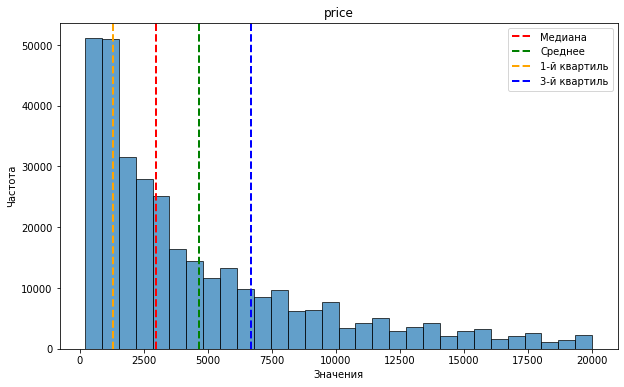

count    334186.000000
mean       2003.348013
std           7.049046
min        1961.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registrationyear, dtype: float64


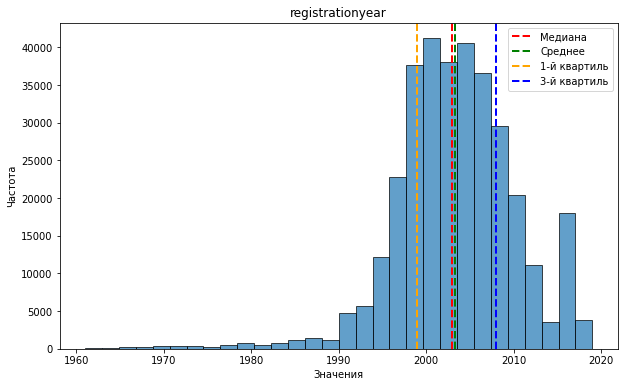

count    334186.000000
mean        109.175935
std          63.086562
min           0.000000
25%          73.000000
50%         105.000000
75%         143.000000
max         999.000000
Name: power, dtype: float64


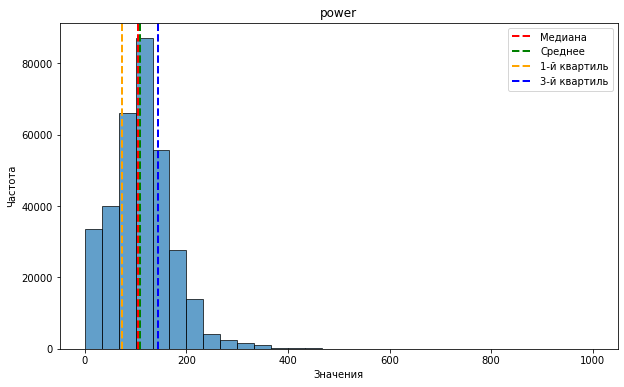

count    334186.000000
mean     128539.271543
std       37028.236571
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


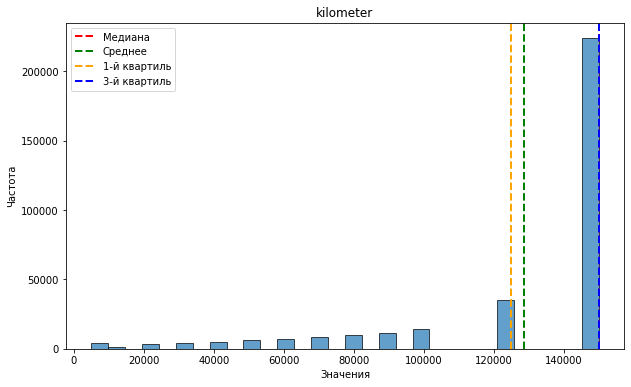

count    334186.000000
mean          5.838802
std           3.673956
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registrationmonth, dtype: float64


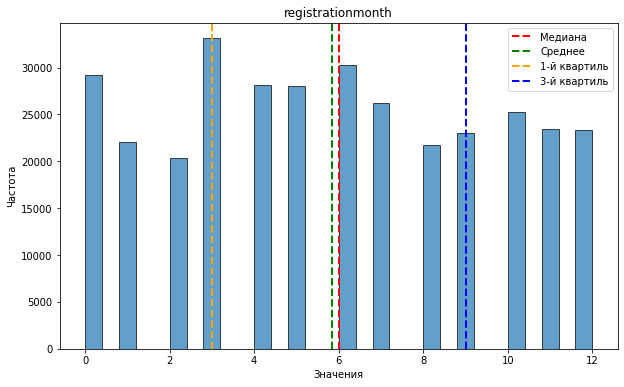

count    334186.000000
mean      50775.224704
std       25703.437538
min        1067.000000
25%       30519.000000
50%       49596.000000
75%       71272.000000
max       99998.000000
Name: postalcode, dtype: float64


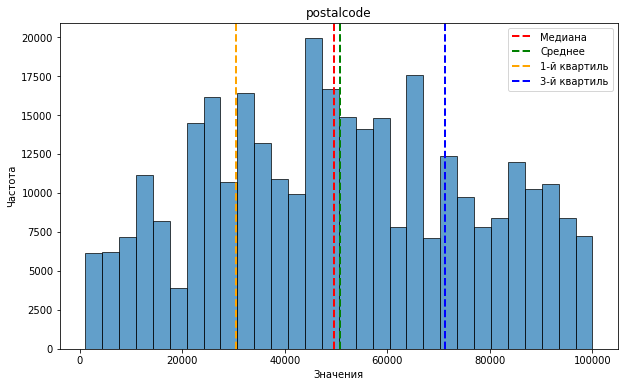

In [44]:
for i in hist_list:
    histagramma(df, i)

no     241722
yes     31191
Name: repaired, dtype: int64


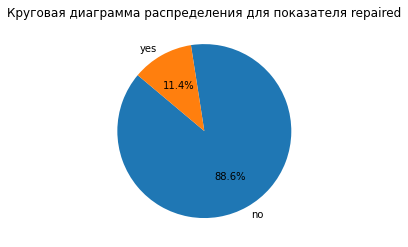

manual    254822
auto       64290
Name: gearbox, dtype: int64


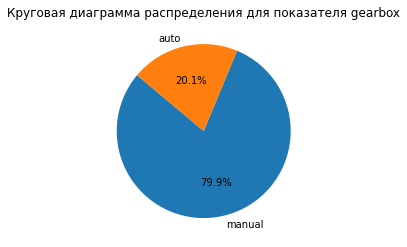

In [45]:
for i in pie_list:
    pie(df, i)

Результаты подсчёта для столбца "vehicletype":


             Количество  Проценты
sedan             88081     29.02
small             74727     24.62
wagon             62846     20.71
bus               28152      9.27
convertible       19726      6.50
coupe             15344      5.06
suv               11712      3.86
other              2939      0.97




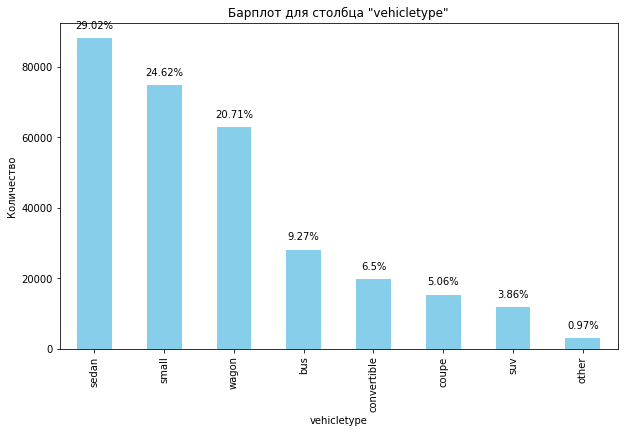

Результаты подсчёта для столбца "brand":
                Количество  Проценты
volkswagen           72523     21.70
opel                 36772     11.00
bmw                  35347     10.58
mercedes_benz        31084      9.30
audi                 28262      8.46
ford                 23167      6.93
renault              16596      4.97
peugeot              10518      3.15
fiat                  8895      2.66
seat                  6543      1.96
skoda                 5385      1.61
mazda                 5336      1.60
smart                 5138      1.54
citroen               4859      1.45
nissan                4640      1.39
toyota                4512      1.35
hyundai               3486      1.04
mini                  3150      0.94
volvo                 3064      0.92
mitsubishi            2812      0.84
honda                 2679      0.80
sonstige_autos        2505      0.75
kia                   2381      0.71
suzuki                2194      0.66
alfa_romeo            2174      0.

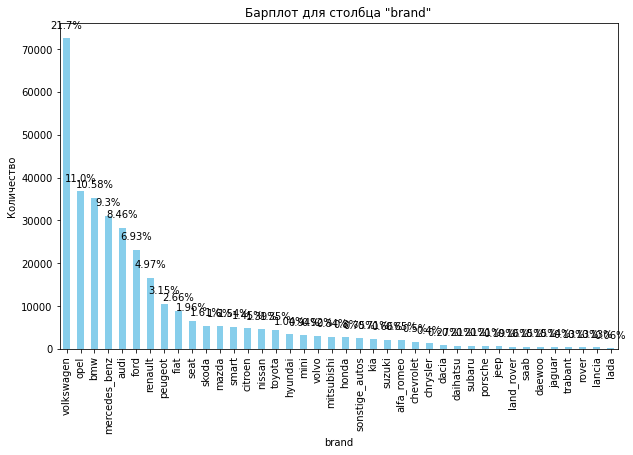

Результаты подсчёта для столбца "fueltype":
          Количество  Проценты
petrol        204817     66.58
gasoline       96704     31.43
lpg             5130      1.67
cng              544      0.18
hybrid           225      0.07
other            141      0.05
electric          85      0.03




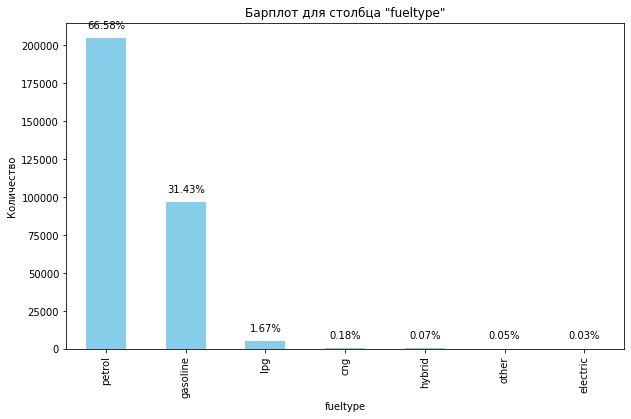

In [46]:
for i in ['vehicletype', 'brand', 'fueltype']:
    barplot(df, i)

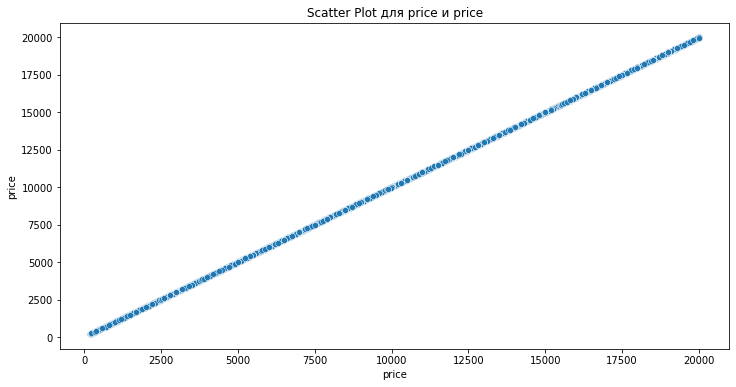

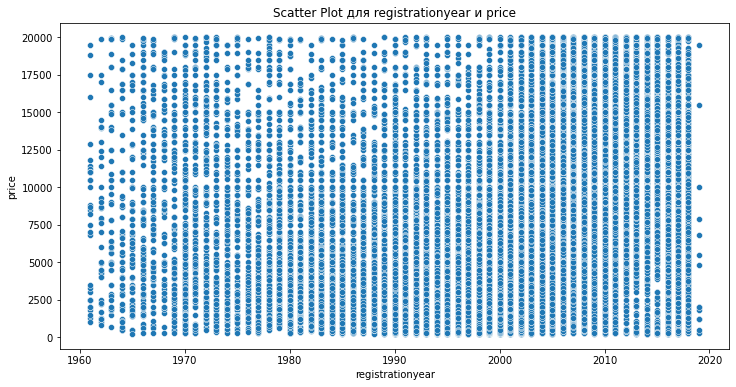

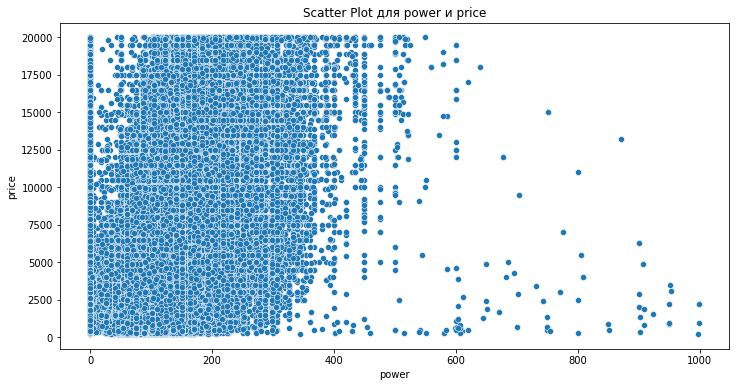

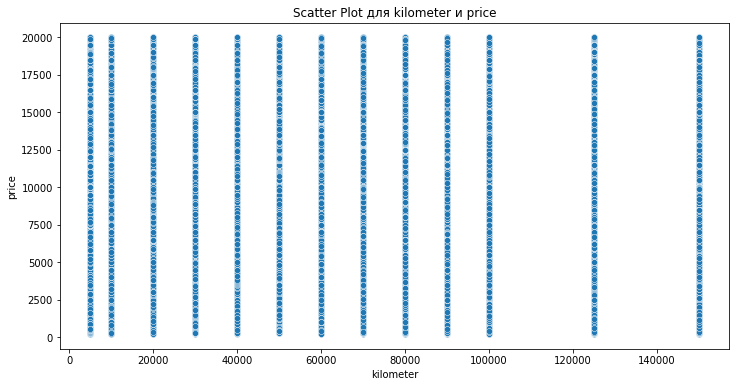

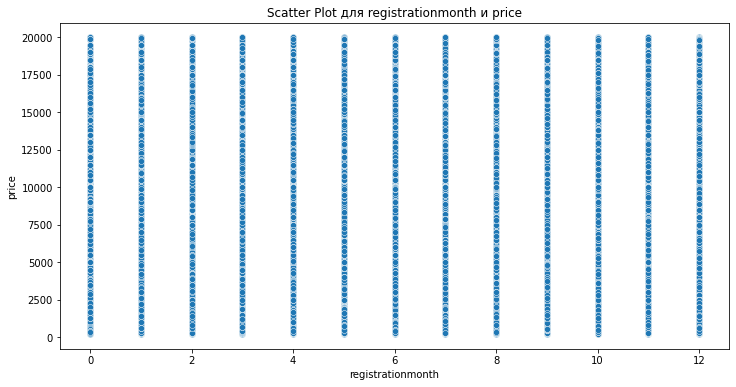

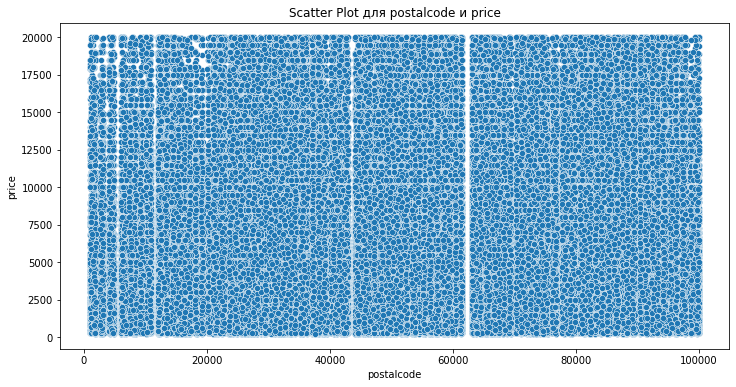

In [47]:
for i in hist_list:
    link(df, i, 'price')

Таблица средних значений:
   vehicletype        price
6          suv  9195.419740
1  convertible  6954.530822
2        coupe  6311.300769
0          bus  5603.347720
7        wagon  5054.315151
4        sedan  4887.813649
3        other  3869.587615
5        small  2850.606247


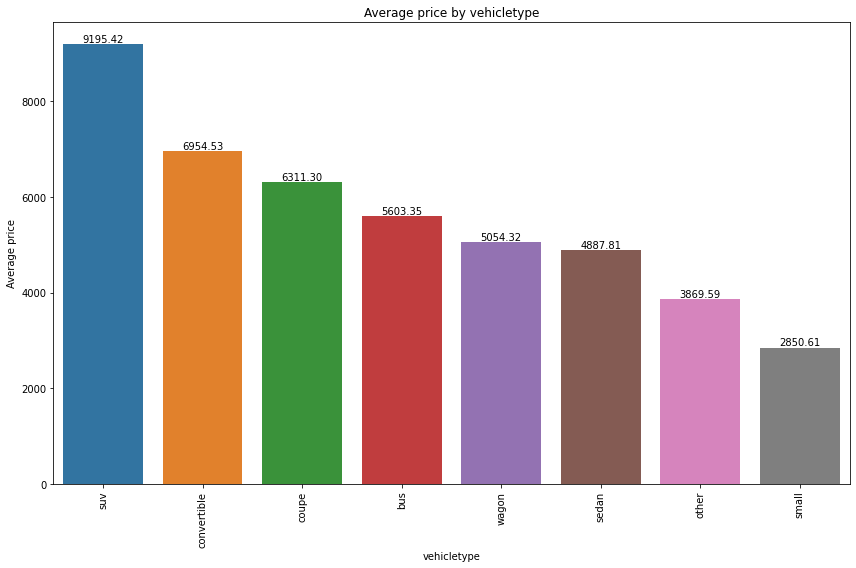

Таблица средних значений:
             brand         price
26         porsche  11994.415584
21            mini   9127.678730
18      land_rover   8607.122180
14            jeep   7295.219092
13          jaguar   6974.530992
1             audi   6498.478169
2              bmw   6426.892579
33  sonstige_autos   6371.979641
20   mercedes_benz   6082.456537
31           skoda   6030.922191
6            dacia   5925.071026
3        chevrolet   5777.020214
12         hyundai   5254.506885
15             kia   5152.581688
36          toyota   4864.820922
38      volkswagen   4642.454614
39           volvo   4444.659269
23          nissan   4341.496121
30            seat   4214.719700
35          suzuki   4097.318140
34          subaru   4018.969828
4         chrysler   3949.471471
0       alfa_romeo   3915.472401
11           honda   3835.478537
29            saab   3803.688363
19           mazda   3802.440030
5          citroen   3635.384235
32           smart   3556.653367
10            for

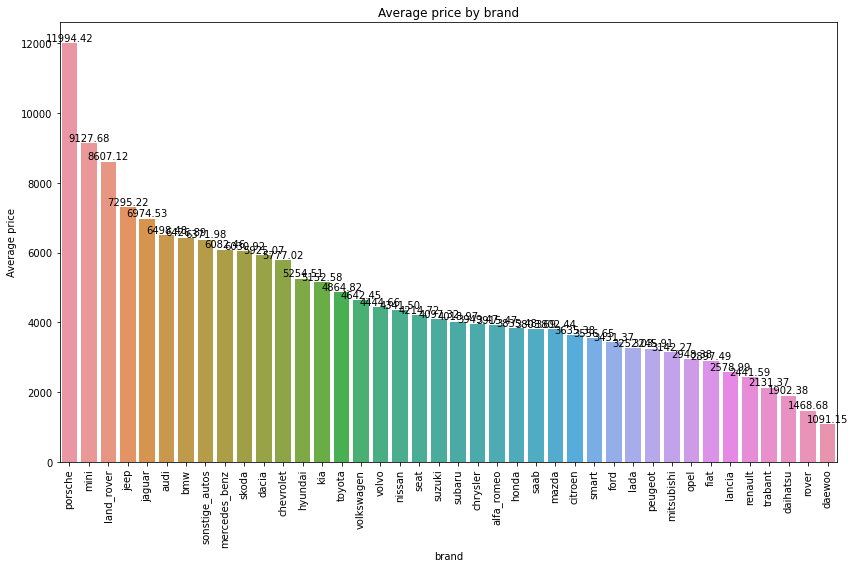

Таблица средних значений:
  repaired        price
0       no  5405.945959
1      yes  2194.012439


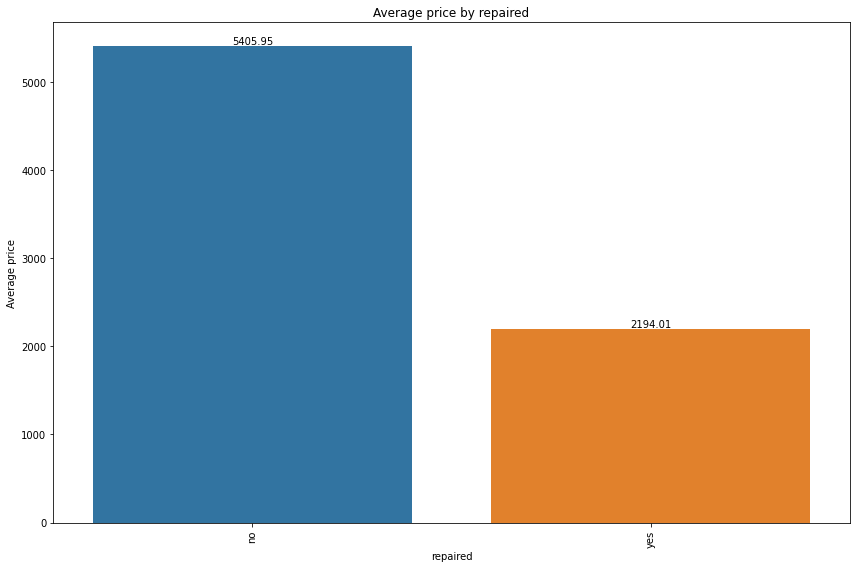

Таблица средних значений:
   fueltype        price
3    hybrid  9801.324444
1  electric  7046.152941
2  gasoline  6711.826377
0       cng  4623.702206
4       lpg  4180.129825
6    petrol  3944.199417
5     other  3227.418440


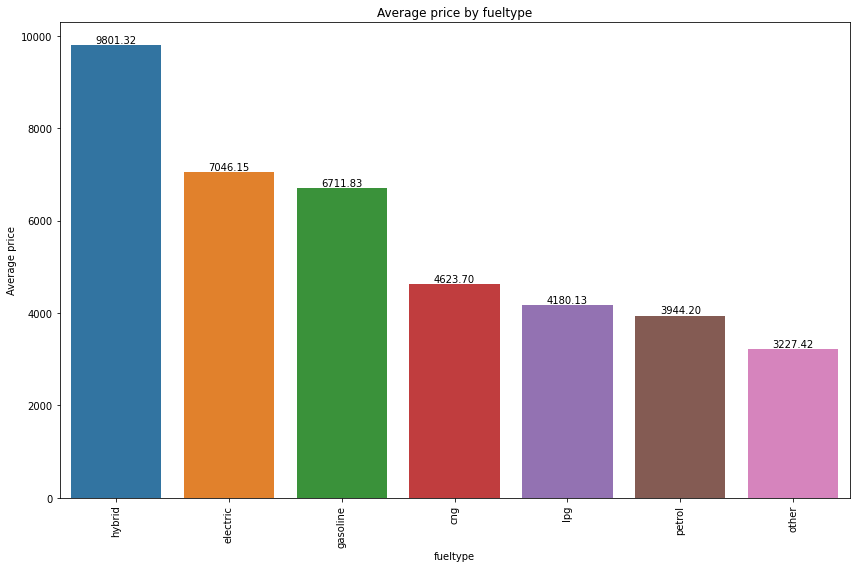

Таблица средних значений:
  gearbox        price
0    auto  7044.551625
1  manual  4176.981230


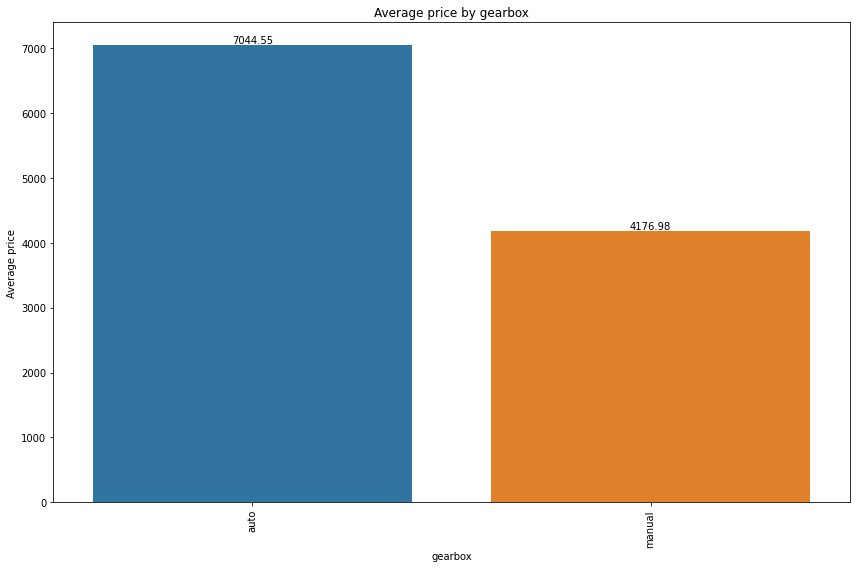

In [48]:
for i in mean_list:
    mean_target(df, i, 'price')

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth', 'postalcode']


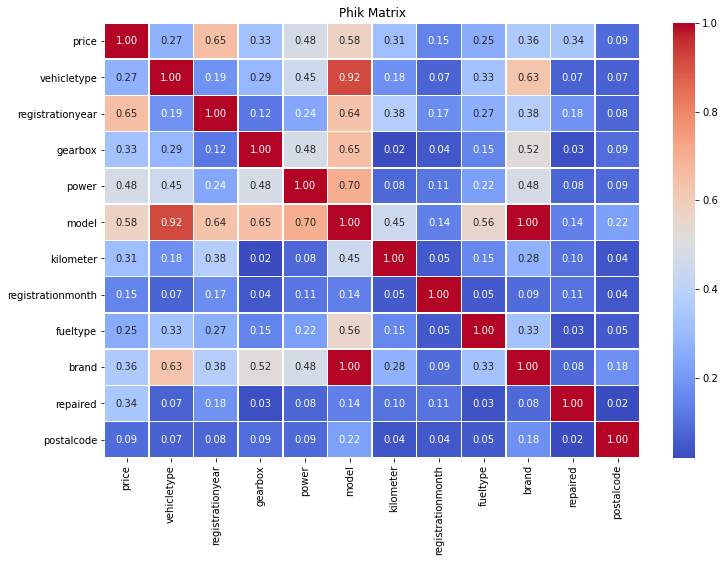

In [49]:
phik_matrix = df.phik_matrix()

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Phik Matrix')
plt.show()

**Выводы из исследовательского анализа:**

1. Большая часть автомобилей имеют цену ниже 5000 евро
2. Зарегетсрирвоанны автомобили преимущественно в первом десятилетии нашего века
3. Мощность двигателя у большинства автомобилей не превышает 200 л.с
4. Чаще всего пробег у предлоденных автомобилей больше 15000 км
5. Всего у 88% ручная коробка передач. У 11 % автоматическая
6. Наиболее встречающиеся типы кузова: sedan, small и wagon
7. Более 10% предложений имею фольсваген, бмв и опель. Немецкий автопром самый востребованный в Европе
8. Больша ячасть авто работают на бенине, небольшая часть на газе, все остальные типы топлива очень редко встречаются
9. Машины, зарегстрирвоанные до 2000 года имеют меньше дорогих предлодений, чем те, которые после 2000
10. Автомобили с мощностью двигателя до 100 л.с имеют меньше дорогих экземпляров,ч ем среди тех, у которых мощность выше 100
11. Автомобили с типами кузова: suv стоят больше всего. На втором месте с convertible, на третьем автобусные.
12. Порше, мини и лэндровер имеют наибольшую среднюю цену среди брэндов
13. Самыми дорогими автомоилями являются те, что имеют гибридный тип двигателя, на электричестве и газу.
14. Машины с автоматической коробкой передач стоят дороже, чем с ручным 
15. На стоимость машины достаточно заметно влияет год регистрации, её мощность, чем выше эти показатели, тем больше цена. Также чем меньше пробег, тем цена будет меньше
16. Также на стоимость оказывает влияние модель автомобиля

# Модель_1

In [50]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,postalcode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334186 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              334186 non-null  int64 
 1   vehicletype        303527 non-null  object
 2   registrationyear   334186 non-null  int64 
 3   gearbox            319112 non-null  object
 4   power              334186 non-null  int64 
 5   model              318040 non-null  object
 6   kilometer          334186 non-null  int64 
 7   registrationmonth  334186 non-null  int64 
 8   fueltype           307646 non-null  object
 9   brand              334186 non-null  object
 10  repaired           272913 non-null  object
 11  postalcode         334186 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 33.1+ MB


In [52]:
non_object_columns = df.drop('price', axis=1).select_dtypes(include=['number']).columns
object_columns = df.select_dtypes(include=['object']).columns

In [53]:
non_object_columns

Index(['registrationyear', 'power', 'kilometer', 'registrationmonth',
       'postalcode'],
      dtype='object')

In [54]:
object_columns

Index(['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired'], dtype='object')

In [55]:
def tts(df):
    X = df.drop(['price'], axis=1)
    y = df['price']
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE)
    return X, y, X_train, X_valid, y_train, y_valid

In [56]:
X, y, X_train, X_test, y_train, y_test = tts(df)

In [57]:

ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, drop='first', handle_unknown="ignore"))  
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, object_columns),
    ('num', StandardScaler(), non_object_columns)
], remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])




In [60]:
param_grid_1 = [
    # KNeighborsRegressor
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': range(1, 20),
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }]

In [61]:
random_search = RandomizedSearchCV(pipe_final, 
                                   param_grid_1,
                                       cv=5,
                                         scoring='neg_mean_squared_error',
                                           random_state=RANDOM_STATE)
random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучшее значение MSE:", random_search.best_score_)

c:\Users\simuk\practicum\practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [71]:
param_grid_1 = [
    # KNeighborsRegressor
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(1, 20),
        'models__weights': ['uniform', 'distance'],
        'models__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }]
param_grid_2 =[
    # DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_split': range(2, 11),  # min_samples_split must be at least 2
        'models__min_samples_leaf': range(1, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }]
paparam_grid_3 =[
    # SVR
    {
        'models': [SVR()],
        'models__C': range(1, 10),
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }]
param_grid_4 = [
    # Lasso
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': np.arange(0.1, 1.0, 0.1),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }]
param_grid_5= [
    # RandomForestRegressor
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(100, 500, 100),
        'models__max_depth': [None] + list(range(5, 16, 5)),
        'models__min_samples_split': range(2, 11, 4),
        'models__min_samples_leaf': range(1, 11, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }]
param_grid = [
    # LinearRegression
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]


In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250639 entries, 161697 to 129354
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicletype        227499 non-null  object
 1   registrationyear   250639 non-null  int64 
 2   gearbox            239276 non-null  object
 3   power              250639 non-null  int64 
 4   model              238516 non-null  object
 5   kilometer          250639 non-null  int64 
 6   registrationmonth  250639 non-null  int64 
 7   fueltype           230709 non-null  object
 8   brand              250639 non-null  object
 9   repaired           204620 non-null  object
 10  postalcode         250639 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 22.9+ MB


In [62]:
model = pipe_final
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired'], dtype='object')),
                                                 ('num', MinMaxScaler(),
                                                  Index(['registrationyear', 'power', 'kilometer', 'registrationmonth',
       'postalcode'],
      dtype='object'))])),
                ('models', LinearRegression())])